# Topic Model
Topic model 是希望演算法能夠自己從一堆文本中，找出潛在主題的一個問題。在這邊我是使用 LDA 作為實現 topic model 的演算法。

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os
import re
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm

import pyLDAvis.gensim

from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

from IPython.display import clear_output
clear_output()

In [2]:
path = os.path.join("..","data","./newdata_clean.xlsx")
n_cpu = 5
batch_size = 10000
max_k = 40
max_features = 256  # only consider the top max_features ordered by term frequency across the corpus.
loadpath = "processed_data_lda_wo_html"
#loadpath = "processed_data_not_rmsw"

n_topic = 80

In [3]:
with open(loadpath, "rb") as f:
    output = pickle.load(f)
clean_data = output["clean_data"]
reduced_data = output["reduced_data"]
token_data = output["token_data"]

## LDA Topic Model

下面我是使用 `gensim` 這個套件來實作 LDA。首先我們會需要根據 Dataset 先建一個 BOW，接著根據 BOW 我們可以再建出 TFIDF。
最後因為 LDA 可以根據 BOW 或是 TFIDF 來算，所以這邊我兩個都分別算過一次。

算完了之後我會先印出所有 topic 他組成的前 10 word distribution，接者再用 `print_topic_example()` 這個 function 把每個 topic 的句子也給印出來，如此可以根據句子來判斷說他屬於這個 topic 是不是合理，也可以藉此推測這個主題所代表的意義。

如果不移除 stopword 的話效果很差，主題的字都會是 of, for, it...

`dictionary.filter_extremes()` 過濾掉 token 出現次數少於15個句子，或是出現在超過一半的句子中。

ref: [Topic Modeling and Latent Dirichlet Allocation (LDA) in Python](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [4]:
import gensim
from gensim.models import LdaMulticore
import pprint
print("Data length: {}".format(len(token_data)))
dictionary = gensim.corpora.Dictionary(token_data)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in token_data]

Data length: 36939


### Visualize

In [5]:
def print_topic_example(reduced_data, token_data, model, dictionary, n_topic):
    print("Model:", model)
    total_len = len(reduced_data)
    print("total_len",total_len)

    topic_distribution = [0 for i in range(n_topic)]
    topic_result = []
    example = [[] for i in range(n_topic)]
    for s, token in tqdm(zip(reduced_data, token_data), total=total_len):
        bow_vector = dictionary.doc2bow(token)
        rank = model[bow_vector]
        if len(rank) == 0:
            continue
        index, score = max(rank, key=lambda tup: tup[1])
        #print(index,score)
        topic_distribution[index] += 1
        topic_result.append(index)
        example[index].append((s, score))
        #print(s)
        #print("Score: {}  Topic: {}\n".format(score, model.print_topic(index, 5)))
    print("topic_distribution: {}".format(topic_distribution))
    
    for idx, topic in model.print_topics(-1):
        print('Topic: {} | {} datas\nWord: {}'.format(idx, topic_distribution[idx], topic))
        result = sorted(example[idx], key=lambda tup: -tup[1])[:5]
        for s, score in result:
            print("{} | {}\n".format(re.sub(r'<[^<]*?/?>', '', s) ,score)) # print sentence remove html tag
        print()
        print("====================")
    
    return topic_result

### LDA using BOW
Topic 的數量如果小於 50 的話，會有很多字像是 download、lost 等一直出現在每個主題的關鍵字中，導致效果很差。經過實驗，topic 的數量設在 70 以上是還不錯的，再上去基本沒有太大的差別。

In [6]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n_topic, id2word=dictionary, passes=2, workers=n_cpu)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    
# Compute Perplexity
per_score = lda_model.log_perplexity(bow_corpus)
print('Perplexity: ', per_score)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=token_data, dictionary=dictionary, coherence='c_v', processes=n_cpu)
coherence_lda = coherence_model_lda.get_coherence() # high is better
print('Coherence Score: ', coherence_lda)

Topic: 0 
Words: 0.054*"powerdvd" + 0.031*"ultra" + 0.019*"upgrade" + 0.019*"version" + 0.017*"power" + 0.016*"purchase" + 0.016*"gpu" + 0.013*"get" + 0.010*"medium" + 0.010*"download"
Topic: 1 
Words: 0.064*"version" + 0.021*"use" + 0.019*"download" + 0.019*"photodirector" + 0.015*"upgrade" + 0.013*"software" + 0.013*"try" + 0.012*"new" + 0.012*"powerdirector" + 0.011*"update"
Topic: 2 
Words: 0.027*"use" + 0.025*"get" + 0.017*"try" + 0.012*"pay" + 0.012*"time" + 0.011*"software" + 0.011*"know" + 0.010*"need" + 0.009*"still" + 0.009*"take"
Topic: 3 
Words: 0.076*"version" + 0.035*"purchase" + 0.032*"upgrade" + 0.022*"download" + 0.020*"buy" + 0.020*"software" + 0.019*"get" + 0.019*"full" + 0.016*"new" + 0.014*"trial"
Topic: 4 
Words: 0.042*"email" + 0.037*"new" + 0.030*"product" + 0.019*"old" + 0.017*"use" + 0.017*"powerdirector" + 0.016*"computer" + 0.015*"buy" + 0.011*"install" + 0.011*"get"
Topic: 5 
Words: 0.038*"download" + 0.022*"email" + 0.021*"get" + 0.019*"purchase" + 0.019*"

In [7]:
bow_topic_result = print_topic_example(reduced_data, token_data, lda_model, dictionary, n_topic)

  0%|          | 83/36939 [00:00<00:44, 827.09it/s]

Model: LdaModel(num_terms=3478, num_topics=80, decay=0.5, chunksize=2000)
total_len 36939


100%|██████████| 36939/36939 [00:53<00:00, 692.10it/s]


topic_distribution: [318, 338, 257, 1365, 516, 407, 134, 120, 818, 479, 99, 317, 501, 193, 112, 193, 370, 200, 715, 376, 150, 368, 140, 189, 974, 747, 400, 138, 372, 381, 240, 832, 175, 179, 474, 77, 94, 1239, 629, 379, 85, 1242, 269, 138, 1178, 2172, 243, 370, 753, 196, 282, 325, 852, 147, 161, 931, 2790, 281, 708, 257, 490, 492, 415, 239, 1076, 336, 320, 302, 279, 290, 127, 283, 92, 221, 472, 260, 520, 609, 428, 303]
Topic: 0 | 318 datas
Word: 0.054*"powerdvd" + 0.031*"ultra" + 0.019*"upgrade" + 0.019*"version" + 0.017*"power" + 0.016*"purchase" + 0.016*"gpu" + 0.013*"get" + 0.010*"medium" + 0.010*"download"
I installed PowerDVD 8 from a CD I had.  Should I uninstall it before installing PowerDVD 11?    Also I see there is a Power2Go 12 essentials that is free.   I installed Power2Go v6.1 from the same CD.      I have Windows 10 Home 64 bit.    I enjoyed using your software in a Windows 7 environment.  I really want the burning capability mainly.    You recommended upgrading from Pow

`pyLDAvis` 是一個視覺化 LDA 的 python package，詳細的意義可以參考原始 paper。

ref: [LDAvis: A method for visualizing and interpreting topics](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)

In [8]:
visual = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(visual)

/tmp2/b05505004/intern/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### LDA using TF-IDF

In [9]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
#print(corpus_tfidf[4310])

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=n_topic, iterations=100000, id2word=dictionary, passes=2, workers=n_cpu)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

# Compute Perplexity
per_score = lda_model_tfidf.log_perplexity(corpus_tfidf)
print('Perplexity: ', per_score)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=token_data, dictionary=dictionary, coherence='c_v', processes=n_cpu)
coherence_lda = coherence_model_lda.get_coherence() # high is better
print('Coherence Score: ', coherence_lda)

Topic: 0 
Word: 0.065*"layer" + 0.064*"requirement" + 0.051*"pic" + 0.044*"asus" + 0.028*"addition" + 0.028*"usage" + 0.027*"whether" + 0.021*"throw" + 0.019*"symbol" + 0.019*"bother"
Topic: 1 
Word: 0.014*"movie" + 0.013*"restart" + 0.009*"program" + 0.009*"video" + 0.009*"produce" + 0.009*"try" + 0.009*"restore" + 0.008*"button" + 0.008*"time" + 0.008*"portion"
Topic: 2 
Word: 0.020*"burn" + 0.017*"hit" + 0.014*"dvd" + 0.012*"compatibility" + 0.012*"sample" + 0.012*"version" + 0.011*"open" + 0.010*"window" + 0.010*"program" + 0.010*"disk"
Topic: 3 
Word: 0.017*"inquiry" + 0.016*"monthly" + 0.015*"response" + 0.013*"diamond" + 0.011*"february" + 0.011*"subscription" + 0.010*"dec" + 0.010*"annual" + 0.010*"email" + 0.009*"fee"
Topic: 4 
Word: 0.121*"burn" + 0.087*"bluray" + 0.052*"disc" + 0.038*"play" + 0.027*"copyright" + 0.027*"camcorder" + 0.019*"data" + 0.017*"writer" + 0.016*"movie" + 0.013*"rhon"
Topic: 5 
Word: 0.043*"footage" + 0.040*"render" + 0.034*"encode" + 0.027*"apple" + 

Perplexity:  -12.655842825891574
Coherence Score:  0.412741340725406


In [10]:
tfidf_topic_result = print_topic_example(reduced_data, token_data, lda_model_tfidf, dictionary, n_topic)

  0%|          | 44/36939 [00:00<01:24, 434.71it/s]

Model: LdaModel(num_terms=3478, num_topics=80, decay=0.5, chunksize=2000)
total_len 36939


100%|██████████| 36939/36939 [01:08<00:00, 542.19it/s]


topic_distribution: [3, 1570, 761, 281, 128, 10, 161, 873, 2010, 241, 284, 579, 118, 1483, 625, 8, 394, 106, 49, 3021, 644, 36, 139, 186, 187, 326, 1358, 24, 44, 27, 488, 157, 11, 45, 2793, 0, 543, 32, 20, 1716, 187, 9, 7, 147, 308, 56, 613, 331, 3, 32, 12, 215, 37, 19, 43, 501, 36, 476, 1245, 1329, 548, 103, 130, 30, 385, 157, 903, 195, 69, 192, 1781, 479, 829, 14, 829, 139, 374, 124, 2400, 171]
Topic: 0 | 3 datas
Word: 0.065*"layer" + 0.064*"requirement" + 0.051*"pic" + 0.044*"asus" + 0.028*"addition" + 0.028*"usage" + 0.027*"whether" + 0.021*"throw" + 0.019*"symbol" + 0.019*"bother"
﻿ Dear Team,    Being an android developer, i couldnt resist myself posting a query for the blur or foggy layer on top of the pictures i click from youcam perfect app.     I have been using youcam for past few months and its one of my fav app for selfies. Everytime i try to capture the pic, on the camera view mode , picture is very clear and crisp. After i click it, i can see some thin layer on top of th

In [11]:
visual = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
pyLDAvis.display(visual)

/tmp2/b05505004/intern/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


為了避免 LDA topic 分得不好，導致不同 topic 的句子數量差異過大，這邊我統計了 BOW 以及 TFIDF 在經過 LDA 計算過後，每個 topic 他所屬句子的數量。

Text(0.5, 1.0, 'TFIDF Topic Distribution')

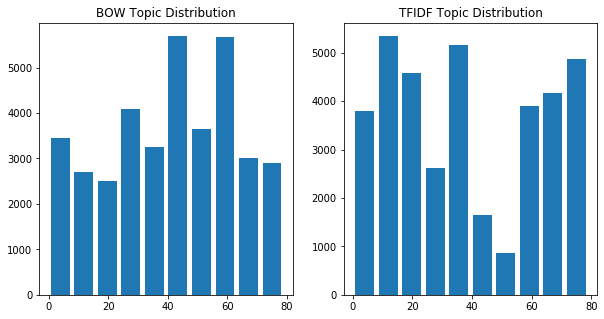

In [12]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(bow_topic_result, rwidth=0.8)   # , c=label_subset_color
ax[0].set_title('BOW Topic Distribution')
ax[1].hist(tfidf_topic_result, rwidth=0.8)   # , c=label_subset_color
ax[1].set_title('TFIDF Topic Distribution')